In [76]:
from rdkit import Chem
from rdkit.Chem import AllChem
from itertools import permutations
import numpy as np
import pandas as pd
from typing import List, Tuple
from rxntools import utils

In [ ]:
JN_rules_df = pd.read_csv("../data/raw/JN1224MIN_rules.tsv", delimiter="\t")

KEGG_processed_df = pd.read_parquet("../data/processed/enzymemap_KEGG_JN_mapped_non_unique.parquet")

In [3]:
query_rule = 'rule0067'
reactant_codes = JN_rules_df[JN_rules_df['Name'] == query_rule]['Reactants'].values[0]
product_codes = JN_rules_df[JN_rules_df['Name'] == query_rule]['Products'].values[0]
rxn_SMARTS = JN_rules_df[JN_rules_df['Name'] == query_rule]['SMARTS'].values[0]
print(reactant_codes, product_codes, rxn_SMARTS)

Any;Any;PYROPHOSPHATE_DONOR_CoF Any;PPI;PYROPHOSPHATE_ACCEPTOR_CoF [#6:1]-[#8:2].[#7:3].[#8:4]-[#15:5]>>[#6:1]-[#7:3].[#8:4].[#8:2]-[#15:5]


In [7]:
KEGG_processed_df[KEGG_processed_df['top_mapped_operator']==query_rule]['unmapped'].to_list()[0]

'N[C@@H](CS)C(=O)O.N[C@H]1[C@@H](O[C@@H]2[C@H](O)[C@H](O)[C@@H](O)[C@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O>>N[C@@H](CS)C(=O)N[C@H]1[C@@H](O[C@@H]2[C@H](O)[C@H](O)[C@@H](O)[C@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]1O.O=P(O)(O)OP(=O)(O)O'

In [39]:
KEGG_processed_df[KEGG_processed_df['top_mapped_operator']==rule_ID]['unmapped'].to_list()[0]


'N[C@@H](CS)C(=O)O.N[C@H]1[C@@H](O[C@@H]2[C@H](O)[C@H](O)[C@@H](O)[C@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O>>N[C@@H](CS)C(=O)N[C@H]1[C@@H](O[C@@H]2[C@H](O)[C@H](O)[C@@H](O)[C@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]1O.O=P(O)(O)OP(=O)(O)O'

In [22]:
rule_ID = 'rule0067'
rule_df = JN_rules_df
rule_SMARTS: str = rule_df[rule_df["Name"]==rule_ID]["SMARTS"].values[0] # of the form 'Any.NAD_CoF>>Any;NADH_CoF'
reactant_codes: str = rule_df[rule_df["Name"]==rule_ID]["Reactants"].values[0] # e.g., 'Any;NAD_CoF'
product_codes: str = rule_df[rule_df["Name"]==rule_ID]["Products"].values[0] # e.g., 'Any;NADH_CoF'

In [23]:
reactant_codes

'Any;Any;PYROPHOSPHATE_DONOR_CoF'

In [ ]:
reactants_SMILES_list: List[str] = ["N[C@@H](CS)C(=O)O", "N[C@H]1[C@@H](O[C@@H]2[C@H](O)[C@H](O)[C@@H](O)[C@H](O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O", "Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O"]
reactants_mols: List[Chem.Mol] = [Chem.MolFromSmiles(smiles) for smiles in reactants_SMILES_list]
useChirality = True
if None in reactants_mols:
    raise ValueError("One or more reactant SMILES could not be converted to RDKit Mol objects.")

all_reactant_combinations: List[Tuple[Chem.Mol, ...]] = list(permutations(reactants_mols, len(reactants_mols)))


lhs_template, rhs_template = rule_SMARTS.split('>>')
lhs_templates_list: List[str] = lhs_template.split('.') # list like [Any_SMARTS, NAD_CoF_SMARTS]
rhs_templates_list: List[str] = rhs_template.split('.') # list like [Any_SMARTS, NADH_CoF_SMARTS]

reactant_codes_list: List[str] = reactant_codes.split(';') # list like ['Any', 'NAD_CoF']
product_codes_list: List[str] = product_codes.split(';') # list like ['Any', 'NADH_CoF']

# initialize a list to store the correct order in which reactants should be positioned based on their SMARTS
# elucidating the correct order is necessary because RDKit's RunReactants() relies on the order of reactants passed to it
correct_reactant_combinations: List[str] = []

# for each combination of reactant positioinings, check if the reactants match their corresponding SMARTS templates
for combination in all_reactant_combinations:

    num_matches = 0

    for (reactant_mol, lhs_template_SMARTS) in zip(combination, lhs_templates_list):
        if reactant_mol.HasSubstructMatch(Chem.MolFromSmarts(lhs_template_SMARTS), useChirality=useChirality):
            num_matches += 1
    
    if num_matches == len(lhs_templates_list):
        correct_reactant_combinations.append(combination)

# use RDKit's AllChem.RunReactants() to run the reaction for each correct reactant combination
all_products: List[Tuple[Chem.Mol, ...]] = []

for correct_combination in correct_reactant_combinations:
    rxn = AllChem.ReactionFromSmarts(rule_SMARTS)
    products: Tuple[Tuple[Chem.Mol, ...], ...] = rxn.RunReactants(correct_combination)
    for product_set in products:
        all_products.append(product_set)

# initialize a list to store the correct order in which products should be positioned based on their SMARTS
correct_product_combinations: List[str] = []

# for each combination of product positionings, check if the products match their corresponding SMARTS templates
for combination in all_products:

    num_matches = 0

    for (product_mol, rhs_template_SMARTS, product_code) in zip(combination, rhs_templates_list, product_codes_list):

        # first, check to see if the product mol object fits its corresponding SMARTS template
        if product_mol.HasSubstructMatch(Chem.MolFromSmarts(rhs_template_SMARTS), useChirality=useChirality):

            # then, if the product is a cofactor (i.e., not 'Any'), check to see that the correct cofactor has been produced
            if product_code != 'Any':
                if utils.are_isomorphic(product_mol, utils.get_cofactor_structure(product_code)):
                    num_matches += 1
                else:
                    continue

            # but if the product is not a cofactor (i.e., 'Any') and its structure fits the corresponding SMARTS template, no further checking is needed
            elif product_code == 'Any':
                num_matches += 1

            else:
                continue

    if num_matches == len(rhs_templates_list):
        correct_product_combinations.append(combination)

In [75]:
product_codes_list

['Any', 'PPI', 'PYROPHOSPHATE_ACCEPTOR_CoF']

In [72]:
len(correct_product_combinations)

117

In [26]:
lhs_templates_list

['[#6:1]-[#8:2]', '[#7:3]', '[#8:4]-[#15:5]']

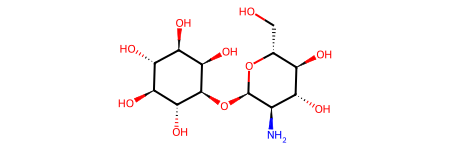

In [16]:
substrate_combinations[1][0]

In [ ]:
def run_JN_rxn(rule_ID: str,
               rule_df: pd.DataFrame,
               substrates_SMILES_list: List[str],
               lhs_cofactors_SMILES_list: List[str],
               consider_stereo: bool = True):
    """
    This function serves as a wrapper around RDKit's AllChem.RunReactants() in two ways.
    First, if consider_stereo=True, we check if the chirality of substrates codified in the rule matches that of the provided substrates.
    Second, we create a tuple of substrates and cofactors in the order that matches that specified in the rule.
    After performing 

    Parameters
    ----------
    rule_ID: str
        unique identifier for the reaction rule to apply, e.g., rule0002 or rule0024_12
    
    rule_df: pd.DataFrame
        pandas dataframe containing SMARTS templates and reactant/ product configurations for each rule_ID
    
    substrates: List[str]
        list of SMILES strings of substrates to apply the specified reaction rule onto
    
    lhs_cofactors: List[str]
        list of SMILES strings of cofactors to apply the specified reaction rule onto
    """
    rule_SMARTS: str = rule_df[rule_df["Name"]==rule_ID]["SMARTS"].values[0] # of the form 'Any.NAD_CoF>>Any;NADH_CoF'
    reactant_codes: str = rule_df[rule_df["Name"]==rule_ID]["Reactants"].values[0] # e.g., 'Any;NAD_CoF'
    product_codes: str = rule_df[rule_df["Name"]==rule_ID]["Products"].values[0] # e.g., 'Any;NADH_CoF'

    lhs_template, rhs_template = rule_SMARTS.split('>>')
    lhs_templates_list: List[str] = lhs_template.split('.') # list like [Any_SMARTS, NAD_CoF_SMARTS]
    reactant_codes_list: List[str] = reactant_codes.split(';') # list like ['Any', 'NAD_CoF']
    product_codes_list: List[str] = product_codes.split(';') # list like ['Any', 'NADH_CoF']

    # initialize an empty tuple of reactants
    reactants_tuple = tuple()

    for lhs_template, reactant_code in zip(lhs_templates_list, reactant_codes_list):
        if reactant_code == 'Any':
            for substrate_SMILES in substrates:
                substrate_mol = Chem.MolFromSmiles(substrate_SMILES)
                if substrate_mol.HasSubstructMatch(query = Chem.MolFromSmarts(lhs_template),
                                                   useChirality = consider_stereo):
                    reactants_tuple += (substrate_mol,)
                    break  # move to the next reactant in the rule
    
    return reactants_tuple

In [14]:
rxn_SMARTS

'[#6:1]-[#7:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1.[#6:9]1:[#6:10]:[#6:11]:[#6:12]:[#7+:13]:[#6:14]:1>>[#6:1]#[#7:2].[#6:11]1=[#6:12]-[#7+0:13]-[#6:14]=[#6:9]-[#6:10]-1.[#6:3]1=[#6:8]-[#7+0:7]-[#6:6]=[#6:5]-[#6:4]-1'

In [51]:
KEGG_processed_df[KEGG_processed_df['top_mapped_operator']=='rule0001']['unmapped'].tolist()[10]

'COc1cc(/C=C/C(=O)O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc(OC)c1O.O=C(O)C[C@H](O)C(=O)O>>COc1cc(/C=C/C(=O)OC(CC(=O)O)C(=O)O)cc(OC)c1O.OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O'

In [63]:

reactants_tuple = run_JN_rxn(rule_ID='rule0001',
                             rule_df=JN_rules_df,
                             substrates=['COc1cc(/C=C/C(=O)O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc(OC)c1O','O=C(O)C[C@H](O)C(=O)O'],
                             lhs_cofactors=[],
                             consider_stereo=True)

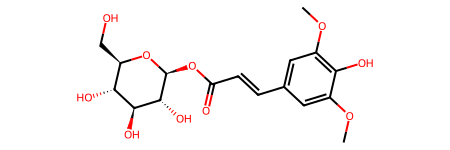

In [60]:
reactants_tuple[1]